[Reference](https://medium.com/@ranton256/classifying-concord-5c68c691f343)

In [1]:
%pip install -q spacy

In [2]:
# you will need to download the spacy model for english.
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import spacy

# Data Acquisition

In [4]:
from pathlib import Path
import requests

In [5]:
emerson_txt_url = "https://www.gutenberg.org/ebooks/16643.txt.utf-8"
thoreau_txt_url = "https://www.gutenberg.org/ebooks/205.txt.utf-8"


def download_file(url):
    local_filename = Path(url.split('/')[-1])
    result = requests.get(url)
    result.raise_for_status()
    with open(local_filename, "wb") as f:
        f.write(result.content)
    return local_filename

emerson_file = download_file(emerson_txt_url)
thoreau_file = download_file(thoreau_txt_url)

In [6]:
!head -n 50 {emerson_file}

﻿The Project Gutenberg eBook of Essays by Ralph Waldo Emerson
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Essays by Ralph Waldo Emerson

Author: Ralph Waldo Emerson

Editor: Edna Henry Lee Turpin

Release date: September 4, 2005 [eBook #16643]
                Most recently updated: April 29, 2022

Language: English

Credits: Curtis A. Weyant, Sankar Viswanathan and the Online Distributed Proofreading Team


*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***




                                ESSAYS

                                  BY

                    

# Text Preprocessing

In [7]:
def trim_frontmatter(filename):
    with open(filename) as f:
        lines = f.readlines()
    n_trim_lines = 0
    for i, line in enumerate(lines):
        if "START OF THE PROJECT GUTENBERG EBOOK" in line:
            n_trim_lines = i + 1
            break
    trimmed_lines = lines[n_trim_lines:]
    trimmed_content = '\n'.join(trimmed_lines)
    new_filename = f"trimmed_{filename}"
    with open(new_filename, "w") as f:
        f.write(trimmed_content)
    return new_filename

In [8]:
trimmed_emerson_file = trim_frontmatter(emerson_file)
trimmed_thoreau_file = trim_frontmatter(thoreau_file)

# Text Segmentation

In [9]:
from collections import deque
from random import randint
import itertools

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
def segment_doc(filename):
    with open(filename) as f:
        text = f.read()
    doc = nlp(text)
    assert doc.has_annotation("SENT_START")
    sent_dq = deque()
    n = randint(3, 5)
    for sent in doc.sents:
        sent_dq.append(sent)
        if len(sent_dq) > n:
            sent_dq.popleft()
        snippet = " ".join(sent.text for sent in sent_dq)
        yield snippet
        n = randint(3, 5)
        sent_dq.clear()

# Dataset Creation

In [12]:
import pandas as pd

def dataframe_from_file(file_path):
  segments = segment_doc(file_path)

  df = pd.DataFrame(segments, columns=["text"])
  return df

In [13]:
# combine and shuffle the datasets, using a consistent random seed.
from sklearn.utils import shuffle

In [14]:
emerson_df = dataframe_from_file(trimmed_emerson_file)
emerson_df["label"] = "emerson"

thoreau_df = dataframe_from_file(trimmed_thoreau_file)
thoreau_df["label"] = "thoreau"

combined_df = pd.concat([emerson_df, thoreau_df])
combined_df = shuffle(combined_df, random_state=7919)

combined_df.to_csv("combined.csv")
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9558 entries, 126 to 4173
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9558 non-null   object
 1   label   9558 non-null   object
dtypes: object(2)
memory usage: 224.0+ KB


,text,label
126,By proper Shelter and Clothing we legitimately...,thoreau
2095,"On land only the grass\n\nand trees wave, but ...",thoreau
3366,The virtues of\n\nsociety are vices of the saint.,emerson
3851,Who.,emerson
3146,The eye is daunted and greatly exaggerates the...,emerson


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# you can start here if csv files were already created.
from sklearn.feature_extraction.text import TfidfVectorizer

/tmp/ipython-input-16-1589112761.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=combined_df["label"], palette="rocket")


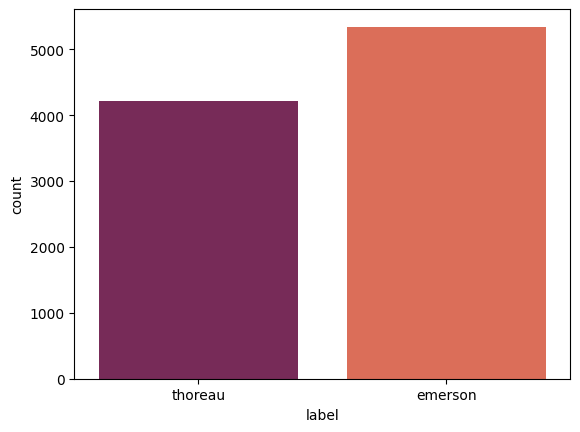

In [16]:
sns.countplot(x=combined_df["label"], palette="rocket")
plt.show()

In [17]:
%pip install -q wordcloud

In [18]:
from spacy.lang.en import STOP_WORDS
my_stopwords = STOP_WORDS

', '.join(my_stopwords)

"everyone, thus, someone, 've, wherever, keep, thereafter, am, together, down, whereas, get, whether, an, fifty, there, ‘ll, wherein, ’ll, done, be, was, put, front, just, who, quite, more, become, even, have, therein, cannot, except, seeming, can, me, anyway, becomes, using, again, since, after, in, were, hers, his, two, both, nothing, we, him, 's, one, herself, latterly, full, my, few, re, once, else, has, show, 'd, thence, will, between, almost, its, along, your, myself, whole, might, very, unless, herein, last, another, as, would, former, below, also, hereupon, that, due, nobody, becoming, moreover, say, amongst, against, could, and, of, too, thereupon, whereafter, upon, some, though, enough, further, whereby, alone, 're, 'll, nevertheless, where, however, ’d, doing, least, other, what, towards, only, still, toward, onto, something, whoever, she, over, why, sometimes, so, whatever, yours, either, them, about, anyone, a, the, nine, ’ve, ourselves, next, well, us, not, by, give, than

In [19]:
# Show wordcloud from each dataset.
from wordcloud import WordCloud


def plot_word_cloud(text_sections, title):
  cloud = WordCloud(background_color='black', stopwords=my_stopwords).generate(str(text_sections))
  fig = plt.figure(figsize=(12,8), facecolor='white')
  plt.imshow(cloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(title, fontsize=48)
  plt.tight_layout(pad=0)
  plt.show()

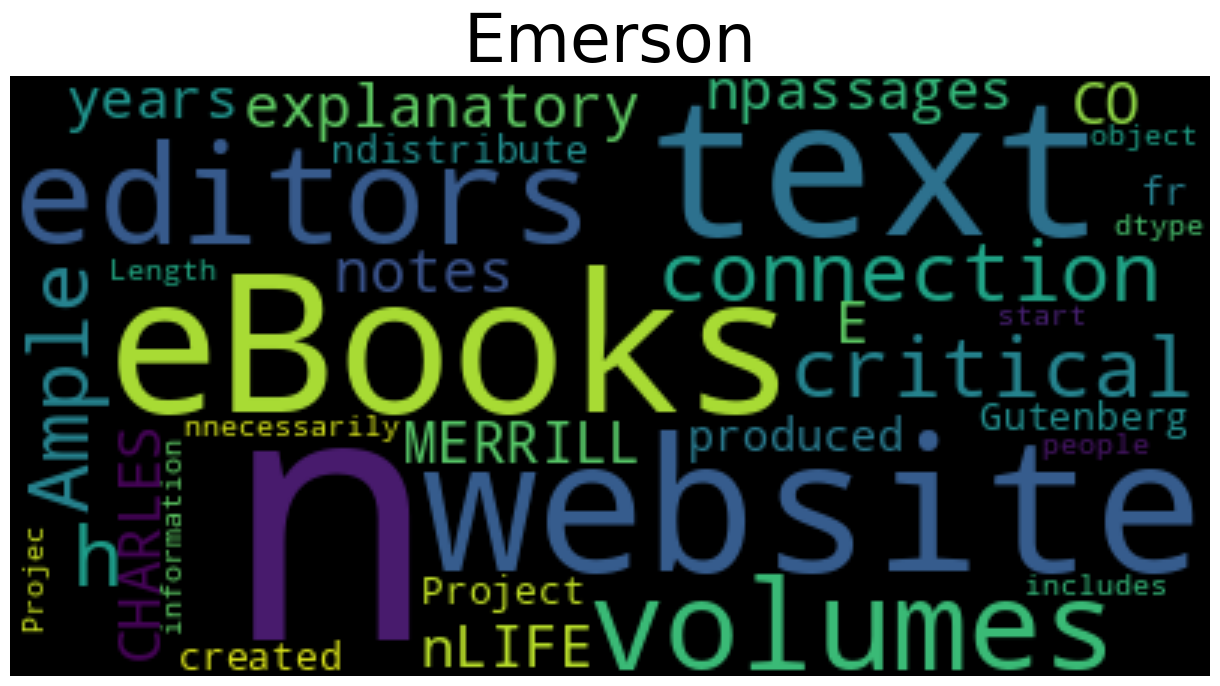

In [20]:
plot_word_cloud(emerson_df["text"], "Emerson")

# Traditional (Non-Transformer) Models

In [21]:
# Preprocess text to remove stopwords, and perform lemmatization.

final_text = []
for index,entry in enumerate(combined_df['text']):
  doc = nlp(entry.lower())
  Final_words = []
  for word in doc:
    if not word.is_stop and not word.is_punct:
      Final_words.append(word.lemma_)
  final_text.append(' '.join(Final_words))

In [22]:
combined_df['final_text'] = final_text
combined_df.head()

,text,label,final_text
126,By proper Shelter and Clothing we legitimately...,thoreau,proper shelter clothing legitimately \n\n reta...
2095,"On land only the grass\n\nand trees wave, but ...",thoreau,land grass \n\n tree wave water ripple wind
3366,The virtues of\n\nsociety are vices of the saint.,emerson,virtue \n\n society vice saint
3851,Who.,emerson,
3146,The eye is daunted and greatly exaggerates the...,emerson,eye daunt greatly exaggerate peril \n\n hour


In [23]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df["final_text"])
y = combined_df["label"]

In [24]:
# split our data into train and test sets.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4909)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (7646, 13025)
y_train: (7646,)
x_test: (1912, 13025)
y_test: (1912,)


In [25]:
from sklearn.linear_model import LogisticRegression

# -2 for n_jobs is all but one CPU available.
lr_model = LogisticRegression(solver='saga', random_state=8102, n_jobs=-2)

lr_model.fit(x_train, y_train)

LogisticRegression(n_jobs=-2, random_state=8102, solver='saga')

In [26]:
y_pred = lr_model.predict(x_test)

In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Markdown, display

def show_metrics(y_test, y_pred, model_name):
  display(Markdown(f"# {model_name}"))

  print(classification_report(y_test,y_pred))
  print("Test accuracy:", accuracy_score(y_test,y_pred))
  cm = confusion_matrix(y_test, y_pred)

  labels = ["emerson", "thoreau"]
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

# Logistic Regression

              precision    recall  f1-score   support

     emerson       0.77      0.87      0.82      1049
     thoreau       0.82      0.69      0.75       863

    accuracy                           0.79      1912
   macro avg       0.80      0.78      0.78      1912
weighted avg       0.79      0.79      0.79      1912

Test accuracy: 0.7902719665271967


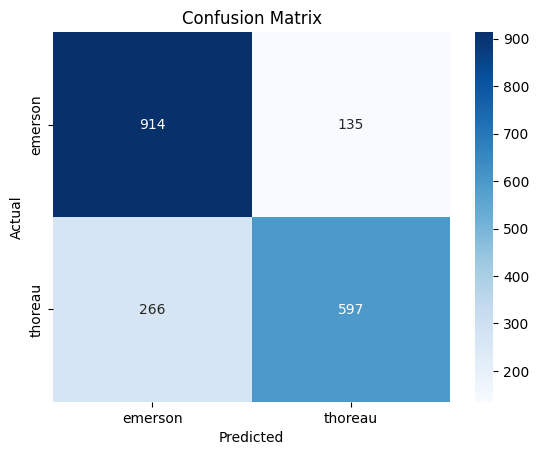

In [28]:
show_metrics(y_test, y_pred, "Logistic Regression")

In [29]:
# Let's compare that to random forests.


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)

RandomForestClassifier()

# Random Forest

              precision    recall  f1-score   support

     emerson       0.75      0.83      0.79      1049
     thoreau       0.76      0.67      0.71       863

    accuracy                           0.75      1912
   macro avg       0.76      0.75      0.75      1912
weighted avg       0.75      0.75      0.75      1912

Test accuracy: 0.75418410041841


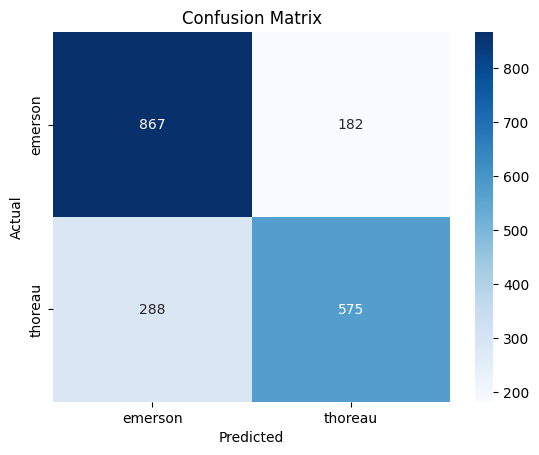

In [30]:
y_pred_rf = rf.predict(x_test)
show_metrics(y_test, y_pred_rf, "Random Forest")

In [31]:
import torch

from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [32]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_token_type_ids = False, padding="max_length", truncation=True)

model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [33]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(combined_df["text"], combined_df["label"], test_size=0.2, random_state=4909)
print(f"x_train_s: {x_train_s.shape}")
print(f"y_train_s: {y_train_s.shape}")
print(f"x_test_s: {x_test_s.shape}")
print(f"y_test_s: {y_test_s.shape}")

x_train_s: (7646,)
y_train_s: (7646,)
x_test_s: (1912,)
y_test_s: (1912,)


In [34]:
x_train_tok = tokenizer(x_train_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_train_tok = y_train_s.tolist()

x_test_tok = tokenizer(x_test_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_test_tok = y_test_s.tolist()

In [35]:
x_train_tok[0:2]

[Encoding(num_tokens=427, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=427, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [36]:
print(x_train_tok.keys())


#move onto device (GPU)
x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}

dict_keys(['input_ids', 'attention_mask'])


/tmp/ipython-input-36-1961297445.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
/tmp/ipython-input-36-1961297445.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}


In [38]:
with torch.no_grad():
  hidden_train = model(**x_train_tok)
  hidden_test = model(**x_test_tok)

# Get the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_test = hidden_test.last_hidden_state[:,0,:]

In [39]:
x_train_db = cls_train.to("cpu")
# y_train_tok

x_test_db = cls_test.to("cpu")
# y_test_tok

In [40]:
lr_model2 = LogisticRegression(C=1, solver='saga', random_state=8102, n_jobs=-2, max_iter=10_000)

lr_model2.fit(x_train_db,y_train_tok)

# This does not converge, with the settings used for TF-DF
# ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
# So we adjusting max_iter and experimented with C (regulation strength).

y_pred = lr_model2.predict(x_test_db)

In [41]:
show_metrics(y_test_tok, y_pred, "Logistic Regression on DistilBERT hidden states")

In [42]:
rf = RandomForestClassifier()
rf.fit(x_train_db,y_train_tok)

rf.score(x_test_db,y_test_tok)

y_pred_rf = rf.predict(x_test_db)

In [43]:
show_metrics(y_test_tok, y_pred_rf, "Random Forest on DistilBERT hidden states")

In [44]:
from sklearn import svm

In [45]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train_db,y_train_tok)

y_pred_svm = clf.predict(x_test_db)

In [46]:
show_metrics(y_test_tok, y_pred_svm, "SVM on DistilBERT hidden states")

In [47]:
from transformers import DistilBertForSequenceClassification

# Define the model with random weights, suitable for binary classification (2 classes)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
# we already have the appropriate tokenizer from before.

In [48]:
# create our optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [49]:
!pip install -q datasets

In [50]:
from sklearn import preprocessing

# Create a copy of our dataframe
trans_df = combined_df.copy()

# drop the preprocessed text column which we aren't using.
trans_df.drop("final_text", axis=1, inplace=True)

# transform our labels into numeric values.
le = preprocessing.LabelEncoder()
my_labels = trans_df["label"].tolist()
le.fit(my_labels)

my_cat_labels = le.classes_
trans_df["label"] = le.transform(trans_df["label"])

print(f"{my_cat_labels=}")

trans_df.info()
trans_df.describe()
trans_df.head()

In [51]:
from datasets import Dataset
from transformers import AutoTokenizer

# for simplicity, we are just splitting the dataset again.
train_df, test_df = train_test_split(trans_df, test_size=0.2, random_state=4909)



train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

In [52]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    # this parameter was apparently removed recently.
    # evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="none" # prevent prompt to login to W & B
)

# Define Trainer object for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


In [53]:
# Save the model.
trainer.save_model('model')

In [54]:
def predictor(text):
  #inputs = tokenizer(text, return_tensors="pt")
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}

  with torch.no_grad():
      logits = model(**inputs).logits
  predictions = torch.argmax(logits, dim=-1)
  return predictions

In [55]:
x_test_trans = test_dataset["text"]
y_test_trans = test_dataset["label"]

# sanity test a few inference inputs.
for txt, lbl in zip(x_test_trans[:5], y_test_trans[:5]):
  pred = predictor( txt)
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")

In [56]:
y_pred_trans = [predictor(txt) for txt in x_test_trans]

for txt, lbl, pred in zip(x_test_trans[:5], y_test_trans[:5], y_pred_trans[:5]):
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")

In [57]:
y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]
y_test_trans = [torch.tensor(v).cpu() for v in y_test_trans]

In [58]:
show_metrics(y_pred_trans, y_test_trans, "Fine-tuned DistilBERT")

In [59]:
def scalar_from_tensor(t):
  if t.dim() == 0:
    return t.item()
  elif t.dim() == 1:
    return t[0].item()
  else:
    raise ValueError(f"Unexpected tensor dimension: {t.dim()}")

In [60]:
y_test_trans = [scalar_from_tensor(t) for t in y_test_trans]
y_pred_trans = [scalar_from_tensor(t) for t in y_pred_trans]

print(f"y_test_trans: {y_test_trans[:5]}")
print(f"y_pred_trans: {y_pred_trans[:5]}")

In [61]:
print("my_cat_labels")

rows = []
for i, (txt, lbl, pred) in enumerate(zip(x_test_trans, y_test_trans, y_pred_trans)):
  if lbl != pred:
    print(f"{lbl=},{pred=}")
    row =(my_cat_labels[lbl], my_cat_labels[pred], txt)
    print(f"{row=}")
    rows.append(row)

n_miss = len(rows)
print(f"Count of misclassified = {n_miss}")
misclassified_df = pd.DataFrame(rows, columns=["actual", "predicted", "text"])
misclassified_df.head(n_miss)

In [62]:
# Preprocess a copy of the data to make it friendly to visualization by length, author, and prediction vs actual.

combined_analysis_df = test_df.copy()
combined_analysis_df['predicted_label_numeric'] = y_pred_trans
combined_analysis_df['predicted_label'] = combined_analysis_df['predicted_label_numeric'].map(lambda x: my_cat_labels[x])
combined_analysis_df.head()

combined_analysis_df['correct'] = combined_analysis_df['label'] == combined_analysis_df['predicted_label_numeric']
combined_analysis_df['correct'] = combined_analysis_df['correct'].astype(int)

correctly_classified_mask = combined_analysis_df['correct'] == 1
combined_analysis_df.loc[correctly_classified_mask, 'Classification'] = 'Correctly Classified'
combined_analysis_df.loc[~correctly_classified_mask, 'Classification'] = 'Incorrectly Classified'

combined_analysis_df['label_string'] = combined_analysis_df['label'].map(lambda x: my_cat_labels[x])
combined_analysis_df['label'] = combined_analysis_df['label_string']
combined_analysis_df.drop('label_string', axis=1, inplace=True)
combined_analysis_df.drop('predicted_label_numeric', axis=1, inplace=True)


combined_analysis_df.loc[:, 'word_count'] = combined_analysis_df['text'].apply(lambda x: len(x.split()))
combined_analysis_df.loc[:, 'char_count'] = combined_analysis_df['text'].apply(lambda x: len(x))


combined_analysis_df.head(n=100)

In [63]:

def analyze_text_lengths(df, classification_column, label_column, text_column):
  analysis_data = {}
  for classification_outcome in df[classification_column].unique():
      classification_df = df[df[classification_column] == classification_outcome]
      classification_name = classification_outcome # Use the actual outcome name
      analysis_data[classification_name] = {}

      # Overall analysis for the classification outcome
      overall_analysis = {
          'Median Words': classification_df['word_count'].median(),
          'Average Words': classification_df['word_count'].mean(),
          'Median Chars': classification_df['char_count'].median(),
          'Average Chars': classification_df['char_count'].mean()
      }
      analysis_data[classification_name]['all'] = overall_analysis

      # Analysis by author within the classification outcome
      if label_column in classification_df.columns:
          for label_value in classification_df[label_column].unique():
              label_df = classification_df[classification_df[label_column] == label_value]
              author_name = my_cat_labels[label_value] if isinstance(label_value, int) else label_value
              label_analysis = {
                  'Median Words': label_df['word_count'].median(),
                  'Average Words': label_df['word_count'].mean(),
                  'Median Chars': label_df['char_count'].median(),
                  'Average Chars': label_df['char_count'].mean()
              }
              analysis_data[classification_name][author_name] = label_analysis

  # Prepare data for the table
  table_data = []
  index = []
  columns = pd.MultiIndex.from_product([df[classification_column].unique(), ['Words', 'Chars']], names=['Classification', 'Count Type'])

  # Add 'all' row first
  row_data_all = {}
  for classification_outcome in df[classification_column].unique():
        classification_name = classification_outcome
        row_data_all[(classification_name, 'Words')] = f"{analysis_data[classification_name]['all']['Median Words']:.2f}/{analysis_data[classification_name]['all']['Average Words']:.2f}"
        row_data_all[(classification_name, 'Chars')] = f"{analysis_data[classification_name]['all']['Median Chars']:.2f}/{analysis_data[classification_name]['all']['Average Chars']:.2f}"
  table_data.append(row_data_all)
  index.append('all')

  # Add rows for each author
  for author_name in ['thoreau', 'emerson']: # Explicitly defined for consistent order
      row_data_author = {}
      for classification_outcome in df[classification_column].unique():
          classification_name = classification_outcome
          if author_name in analysis_data[classification_name]:
              row_data_author[(classification_name, 'Words')] = f"{analysis_data[classification_name][author_name]['Median Words']:.2f}/{analysis_data[classification_name][author_name]['Average Words']:.2f}"
              row_data_author[(classification_name, 'Chars')] = f"{analysis_data[classification_name][author_name]['Median Chars']:.2f}/{analysis_data[classification_name][author_name]['Average Chars']:.2f}"
          else: # Handle missing author.
                row_data_author[(classification_name, 'Words')] = "N/A"
                row_data_author[(classification_name, 'Chars')] = "N/A"

      table_data.append(row_data_author)
      index.append(author_name)

  analysis_table = pd.DataFrame(table_data, index=index, columns=columns)

  # Split by chars and words.
  word_count_table = analysis_table.iloc[:, analysis_table.columns.get_level_values(1) == 'Words'].copy()
  char_count_table = analysis_table.iloc[:, analysis_table.columns.get_level_values(1) == 'Chars'].copy()

  print("\nWord Count (Median/Average):")
  display(word_count_table)

  print("\nCharacter Count (Median/Average):")
  display(char_count_table)

In [64]:
def plot_text_length_density(df, classification_column, label_column, text_column):
  # Density plot for Word Count
  g = sns.FacetGrid(df, col=classification_column, hue=label_column, palette='viridis', sharey=False, height=5, aspect=0.9)
  g.map(sns.kdeplot, 'word_count', fill=True, alpha=0.5)
  g.add_legend(title='Author')
  g.fig.suptitle('Density of Word Count by Classification Outcome and Author', y=1.02)
  g.set_axis_labels("Number of Words", "Density")
  g.set_titles("{col_name}")
  plt.show()

  # Density plot for Character Count
  g = sns.FacetGrid(df, col=classification_column, hue=label_column, palette='viridis', sharey=False, height=5, aspect=0.9)
  g.map(sns.kdeplot, 'char_count', fill=True, alpha=0.5)
  g.add_legend(title='Author')
  g.fig.suptitle('Density of Character Count by Classification Outcome and Author', y=1.02)
  g.set_axis_labels("Number of Characters", "Density")
  g.set_titles("{col_name}")
  plt.show()

In [65]:
plot_text_length_density(combined_analysis_df.copy(), 'Classification', 'label', 'text')

In [66]:
analyze_text_lengths(combined_analysis_df.copy(), 'Classification', 'label', 'text')